## Plotting US State data | May 2019

Georgia Gov. Brian Kemp in early May signed into law a so-called “heartbeat” bill, banning abortion as early as six weeks into pregnancy. This mini-project aims to use geopandas to visualise US state demographics by scraping state-level data from Wikipedia and US News to create choropleth maps. I consider education attainment rates, US House Rep/Dem seats, religiosity, maternal mortality rate (MMR/10,000), urbanisation rate and higher education rankings. 

This project can be expanded by using county level data for higher definition, though certain metrics may not be available at the county level. 

In [92]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

### State education attainment data

I pull state educational attainment data from Wikipedia. 

In [93]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment').text
soup = BeautifulSoup(website_url,'lxml')
edu_table = soup.find('table',{'class':'wikitable sortable'})
edu_dfs = pd.read_html(str(edu_table))
edu_df = edu_dfs[0]
edu_df = edu_df[edu_df.Rank.notnull()]
edu_df = edu_df.rename(index=str, columns={"State, federal district, or territory": "State",
                       "% High school graduate or higher": "highschool_rate",
                       "Rank": "highschool_rate_rank",
                       "% Bachelor's degree or higher": "bachelor_rate",
                       "Rank.1": "bachelor_rate_rank",
                       "% Advanced degree": "advdeg_rate",
                       "Rank.2": "advdeg_rate_rank"})
edu_df = edu_df.astype({"highschool_rate_rank": int, "bachelor_rate_rank": int, "advdeg_rate_rank": int})
edu_df = edu_df[["State", 'highschool_rate', "bachelor_rate","advdeg_rate"]]

edu_df['highschool_rate'] = edu_df['highschool_rate'].str.replace('%', '')
edu_df['highschool_rate'] = edu_df['highschool_rate'].astype(float)
edu_df['bachelor_rate'] = edu_df['bachelor_rate'].str.replace('%', '')
edu_df['bachelor_rate'] = edu_df['bachelor_rate'].astype(float)
edu_df['advdeg_rate'] = edu_df['advdeg_rate'].str.replace('%', '')
edu_df['advdeg_rate'] = edu_df['advdeg_rate'].astype(float)

edu_df.head()

,State,highschool_rate,bachelor_rate,advdeg_rate
0,Montana,93.0,30.7,10.1
1,New Hampshire,92.8,36.0,13.8
2,Minnesota,92.8,34.8,11.8
3,Wyoming,92.8,26.7,9.3
4,Alaska,92.4,29.0,10.4


### Manually inserting state abortion law data

I compile the list of states that have passed or considered the heartbeat bill, as well as the three states that have protections for abortion rights. 

In [94]:
abort_df = edu_df["State"].copy().to_frame()

fetal_heartbeat_law_states = ["Ohio", 
                              "Kentucky", 
                              "Mississippi", 
                              "Georgia", 
                              "Alabama"]

consider_abortion_restriction_states = fetal_heartbeat_law_states +["Utah", 
                                        "Arkansas", 
                                        "Florida",
                                        "Louisiana",
                                        "South Carolina",
                                        "Minnestoa",
                                        "West Virginia",
                                        "Missouri",
                                        "Tennessee"] 

abortion_protection_states = ["New York", "Virginia", "Kansas"]

abort_df["fetal_heartbeat_law"] = np.zeros(len(abort_df.index), dtype=int)
for st in fetal_heartbeat_law_states:
    abort_df.loc[abort_df['State'] == st, "fetal_heartbeat_law"] = 1

abort_df["consider_abortion_restriction"] = np.zeros(len(abort_df.index), dtype=int)
for st in consider_abortion_restriction_states:
    abort_df.loc[abort_df['State'] == st, "consider_abortion_restriction"] = 1
    
abort_df["abortion_protection"] = np.zeros(len(abort_df.index), dtype=int)
for st in abortion_protection_states:
    abort_df.loc[abort_df['State'] == st, "abortion_protection"] = 1

abort_df.sort_values(by = ["consider_abortion_restriction","State"], ascending=False).head()

,State,fetal_heartbeat_law,consider_abortion_restriction,abortion_protection
42,West Virginia,0,1,0
9,Utah,0,1,0
38,Tennessee,0,1,0
37,South Carolina,0,1,0
25,Ohio,1,1,0


### State politics data

I use the seat makeup in the House as a proxy for political views within a particular state. 

In [95]:
website_url = requests.get('https://en.wikipedia.org/wiki/2016_United_States_elections').text
soup = BeautifulSoup(website_url,'lxml')
election_table = soup.find('table',{'class':'wikitable sortable'})
housedem_dfs = pd.read_html(str(election_table))
housedem_df = housedem_dfs[0]
housedem_df = housedem_df[0:50]
housedem_df.head()
housedem_df = housedem_df.drop('Before 2016 elections[18]', axis=1, level=0)
housedem_df.columns = housedem_df.columns.droplevel()
housedem_df = housedem_df.rename(columns={'Subdivision': 'State'})
housedem_df = housedem_df[["State","US House"]]
housedem_df = housedem_df.iloc[:,0:2]
housedem_df.head()

,State,US House
0,Alabama,Rep 6–1
1,Alaska,Rep 1–0
2,Arizona,Rep 5–4
3,Arkansas,Rep 4–0
4,California,Dem 39–14


In [96]:
housedem_df["party"], housedem_df["seats"] = housedem_df["US House"].str.split(" ",n=1).str
housedem_df["seata"], housedem_df["seatb"] = housedem_df["seats"].str.split("–", n=1).str
housedem_df.head()
housedem_df["seata"] = pd.to_numeric(housedem_df["seata"])
housedem_df["seatb"] = pd.to_numeric(housedem_df["seatb"])
housedem_df.head()

,State,US House,party,seats,seata,seatb
0,Alabama,Rep 6–1,Rep,6–1,6,1
1,Alaska,Rep 1–0,Rep,1–0,1,0
2,Arizona,Rep 5–4,Rep,5–4,5,4
3,Arkansas,Rep 4–0,Rep,4–0,4,0
4,California,Dem 39–14,Dem,39–14,39,14


In [97]:
housedem_df["housedem_ratio"] = housedem_df.seata / (housedem_df.seata + housedem_df.seatb)
housedem_df.loc[housedem_df.party =="Rep", "housedem_ratio"] = housedem_df.seatb / (housedem_df.seata + housedem_df.seatb)
housedem_df['dem'] = housedem_df['party'].map({'Rep': 0, 'Dem': 1, "Split": 0.5})
housedem_df['houserepub_ratio'] = housedem_df["housedem_ratio"].transform(lambda x: 1-x)
housedem_df = housedem_df[["State", "housedem_ratio", "houserepub_ratio", "dem"]]
housedem_df.head()

,State,housedem_ratio,houserepub_ratio,dem
0,Alabama,0.142857,0.857143,0.0
1,Alaska,0.000000,1.000000,0.0
2,Arizona,0.444444,0.555556,0.0
3,Arkansas,0.000000,1.000000,0.0
4,California,0.735849,0.264151,1.0


### Scraping state religiosity data

I again pull data from Wikipedia. 

In [98]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_religiosity').text
soup = BeautifulSoup(website_url,'lxml')
religion_table = soup.findAll("table", class_ = "wikitable sortable")
religion_dfs = pd.read_html(str(religion_table))
religion_df = religion_dfs[1]
religion_df.head()
religion_df = religion_df.rename(columns={'State, Territory,or District': "State", 
                                          'Percentage stating that religion is "very important" or "somewhat important"': "religiosity",
                                          'Percent Religious, 2014[10][A]': "percent_religious"})

religion_df = religion_df[religion_df.religiosity != '—']
religion_df = religion_df[["State", "religiosity", "percent_religious"]]
religion_df['religiosity'] = religion_df['religiosity'].str.replace('%', '')
religion_df['religiosity'] = religion_df['religiosity'].astype(float)
religion_df['percent_religious'] = religion_df['percent_religious'].str.replace('%', '')
religion_df['percent_religious'] = religion_df['percent_religious'].astype(float)

religion_df.head()

,State,religiosity,percent_religious
0,California,73.0,73.0
1,Texas,86.0,82.0
2,Florida,78.0,76.0
3,New York,72.0,73.0
4,Illinois,77.0,78.0


### Scraping state maternal mortality rate (per 10,000) data

I again pull data from Wikipedia. 

In [99]:
website_url = requests.get('https://en.wikipedia.org/wiki/Maternal_mortality_in_the_United_States').text
soup = BeautifulSoup(website_url,'lxml')
mmr_table = soup.find('table',{'class':'wikitable'})
mmr_dfs = pd.read_html(str(mmr_table))
mmr_df = mmr_dfs[0]
mmr_df = mmr_df.rename(columns={'Status': "mmr_rank", "MMR*": "mmr"})
mmr_df.head()


,State,mmr_rank,mmr
0,California,1,4.5
1,Massachusetts,2,6.1
2,Nevada,3,6.2
3,Colorado,4,11.3
4,Hawaii,5,11.7


### Importing state urbanisation data

Data source: US News

In [100]:
rural_df = pd.read_csv("rural.csv")
rural_df.head()

,State,rural
0,Alabama,41.0
1,Alaska,34.0
2,Arizona,10.2
3,Arkansas,43.8
4,California,5.0


### Importing state education data

Data source: US News

In [101]:
us_news_df = pd.read_csv("usnews_rank.csv")
us_news_df.head()

,State,overall_rank,higher_ed_rank,pre_k_12_rank
0,Massachusetts,1,27,1
1,New Jersey,2,30,2
2,Florida,3,1,27
3,Washington,4,2,19
4,New Hampshire,5,37,3


### Merging all data frames

In [102]:
df = pd.merge(edu_df, abort_df, on="State")
df = pd.merge(df, us_news_df, on="State")
df = pd.merge(df, housedem_df, on="State")
df = pd.merge(df, mmr_df, on="State")
df = pd.merge(df, rural_df, on="State")
df = pd.merge(df, religion_df, on="State")

df.head()

,State,highschool_rate,bachelor_rate,advdeg_rate,fetal_heartbeat_law,consider_abortion_restriction,abortion_protection,overall_rank,higher_ed_rank,pre_k_12_rank,housedem_ratio,houserepub_ratio,dem,mmr_rank,mmr,rural,religiosity,percent_religious
0,Montana,93.0,30.7,10.1,0,0,0,26,19,20,0.000,1.000,0.0,37,24.4,44.1,69.0,70.0
1,New Hampshire,92.8,36.0,13.8,0,0,0,5,37,3,0.500,0.500,0.5,19,16.8,39.7,60.0,64.0
2,Minnesota,92.8,34.8,11.8,0,0,0,17,20,12,0.625,0.375,1.0,8,13.0,26.7,74.0,80.0
3,Wyoming,92.8,26.7,9.3,0,0,0,16,3,34,0.000,1.000,0.0,38,24.6,35.2,77.0,74.0
4,North Dakota,92.3,28.9,7.8,0,0,0,20,5,35,0.000,1.000,0.0,26,18.9,40.1,76.0,80.0


In [103]:
df.dtypes

State                             object
highschool_rate                  float64
bachelor_rate                    float64
advdeg_rate                      float64
fetal_heartbeat_law                int64
consider_abortion_restriction      int64
abortion_protection                int64
overall_rank                       int64
higher_ed_rank                     int64
pre_k_12_rank                      int64
housedem_ratio                   float64
houserepub_ratio                 float64
dem                              float64
mmr_rank                           int64
mmr                              float64
rural                            float64
religiosity                      float64
percent_religious                float64
dtype: object

In [104]:
df.loc[df["consider_abortion_restriction"]==0].sort_values(by=["bachelor_rate"], ascending=True).head()

,State,highschool_rate,bachelor_rate,advdeg_rate,fetal_heartbeat_law,consider_abortion_restriction,abortion_protection,overall_rank,higher_ed_rank,pre_k_12_rank,housedem_ratio,houserepub_ratio,dem,mmr_rank,mmr,rural,religiosity,percent_religious
39,Nevada,85.8,23.7,8.1,0,0,0,45,18,48,0.250000,0.750000,0.0,3,6.2,5.8,73.0,72.0
30,Oklahoma,87.5,24.8,8.3,0,0,0,39,28,43,0.000000,1.000000,0.0,34,23.4,33.8,87.0,82.0
28,Indiana,88.3,25.3,9.2,0,0,0,24,39,6,0.222222,0.777778,0.0,46,41.4,27.6,78.0,74.0
3,Wyoming,92.8,26.7,9.3,0,0,0,16,3,34,0.000000,1.000000,0.0,38,24.6,35.2,77.0,74.0
16,Idaho,90.2,26.8,8.5,0,0,0,33,35,26,0.000000,1.000000,0.0,31,21.2,29.4,76.0,73.0


### Importing US state shapefile

I admit the US shapefile from ArcGIS for the lower 48 states. 

In [105]:
usa = gpd.read_file("./states_21basic/states.shp").to_crs('+proj=robin')
usa = usa.rename(columns = {"STATE_NAME": "State"})
usa = usa[usa['State'].isin(['Alaska','Hawaii']) == False]
usa.head()

,State,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-10157799.2785004 5142668.565902971...
2,Montana,3,30,Mountain,MT,POLYGON ((-9455429.903638316 4773744.387236617...
3,Maine,4,23,New England,ME,(POLYGON ((-5940573.010278355 4707605.90017479...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-8312283.631303364 4903615.899383536...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-8805858.996239154 4593761.721810627...


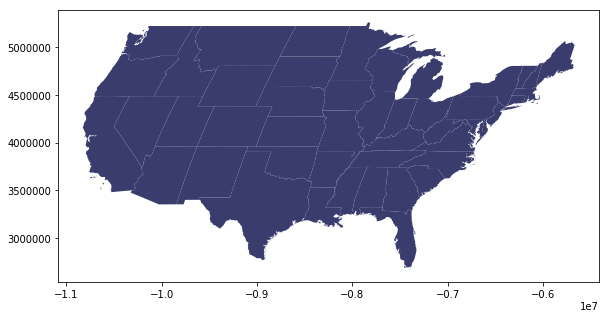

In [106]:
# omitting Hawaii and Alaska
usa[usa['State'].isin(['Alaska','Hawaii']) == False].plot(figsize=(10,5), color='#3B3C6E')

### Merging shapefile with state data

In [107]:
merged = usa.merge(df, left_on='State', right_on='State')
merged.head()

,State,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry,highschool_rate,bachelor_rate,advdeg_rate,fetal_heartbeat_law,...,higher_ed_rank,pre_k_12_rank,housedem_ratio,houserepub_ratio,dem,mmr_rank,mmr,rural,religiosity,percent_religious
0,Washington,2,53,Pacific,WA,(POLYGON ((-10157799.2785004 5142668.565902971...,90.8,34.5,12.7,0,...,2,19,0.6,0.4,1.0,13,14.8,15.9,67.0,68.0
1,Montana,3,30,Mountain,MT,POLYGON ((-9455429.903638316 4773744.387236617...,93.0,30.7,10.1,0,...,19,20,0.0,1.0,0.0,37,24.4,44.1,69.0,70.0
2,Maine,4,23,New England,ME,(POLYGON ((-5940573.010278355 4707605.90017479...,92.1,30.3,10.9,0,...,34,17,0.5,0.5,0.5,15,15.7,61.3,63.0,69.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-8312283.631303364 4903615.899383536...,92.3,28.9,7.8,0,...,5,35,0.0,1.0,0.0,26,18.9,40.1,76.0,80.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-8805858.996239154 4593761.721810627...,91.4,27.8,8.3,0,...,10,23,0.0,1.0,0.0,41,28.0,43.3,81.0,82.0


In [108]:
df.columns

Index(['State', 'highschool_rate', 'bachelor_rate', 'advdeg_rate',
       'fetal_heartbeat_law', 'consider_abortion_restriction',
       'abortion_protection', 'overall_rank', 'higher_ed_rank',
       'pre_k_12_rank', 'housedem_ratio', 'houserepub_ratio', 'dem',
       'mmr_rank', 'mmr', 'rural', 'religiosity', 'percent_religious'],
      dtype='object')

### Plotting choropleth map of states

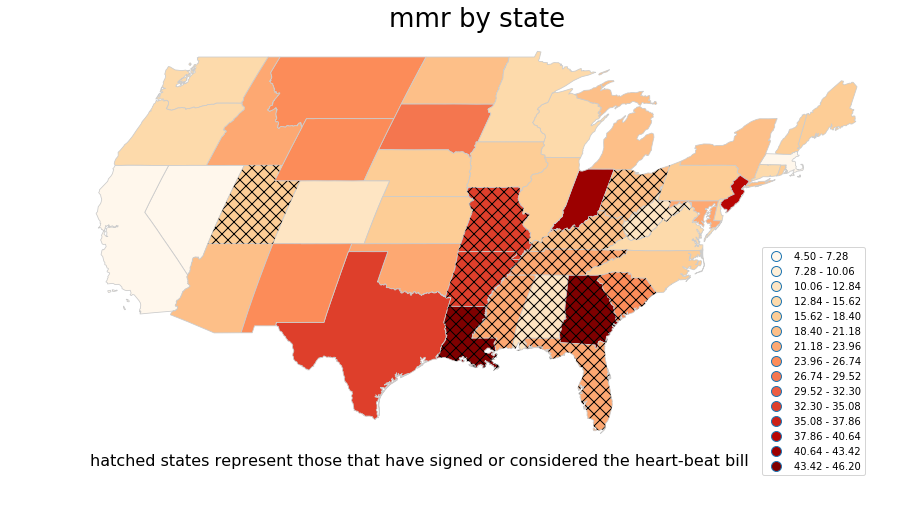

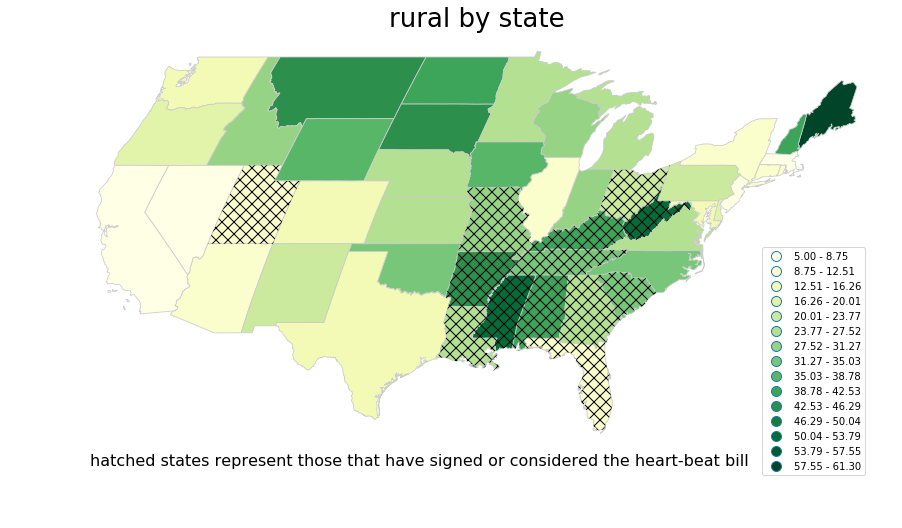

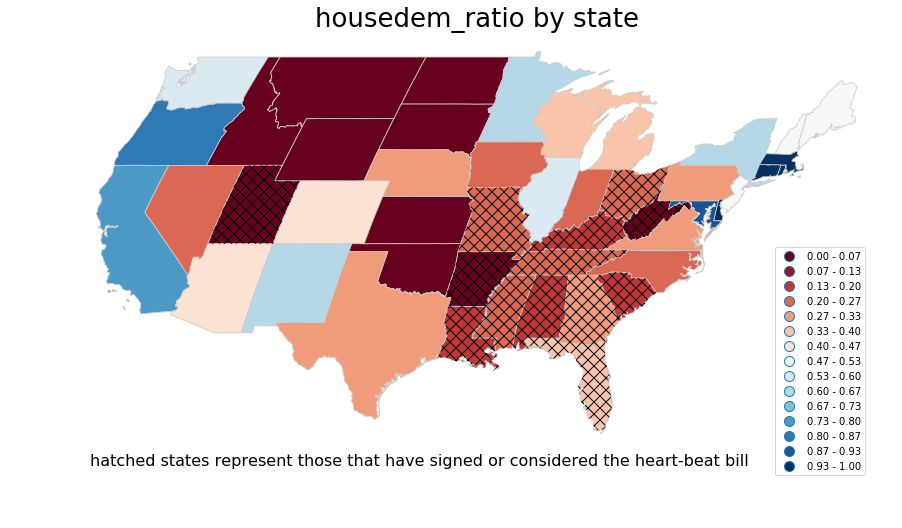

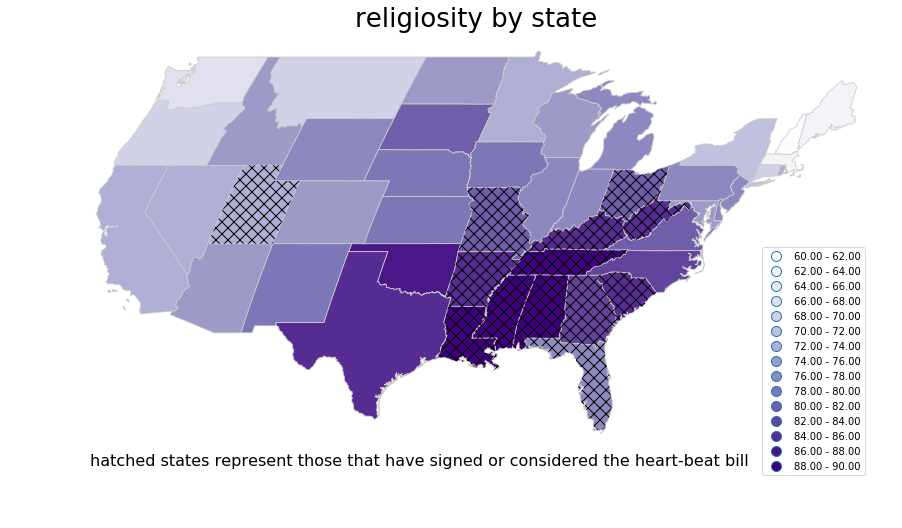

In [109]:
# Parameters to plot by state with colormaps
plotAndcolor = {"mmr": 'OrRd',
                "rural": 'YlGn',
                "housedem_ratio": 'RdBu',
                "religiosity": 'Purples'
                }

for var, color in plotAndcolor.items(): 
    
    # Number of choropleth bins
    colors = 15
    
    cmap = color
    figsize = (15, 10)
    title = '{} by state'.format(var)
    description = "hatched states represent those that have signed or considered the heart-beat bill"
    hatch1 = "consider_abortion_restriction"
    hatch2 = "fetal_heartbeat_law"
    
    ax = merged.dropna().plot(column=var, cmap=cmap, figsize=figsize, scheme='equal_interval', linewidth=0.8, k=colors, edgecolor="0.8", legend=True)
    ax.set_axis_off()
    ax.set_title(title, fontdict={'fontsize': 26}, loc='center')
    ax.annotate(description, xy=(0.1, 0.12), size=16, xycoords='figure fraction')
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((0., 0., .97, .5))
    
    merged[merged[hatch1] == 1].plot(ax=ax, alpha=.0, hatch="xx")
